<a href="https://colab.research.google.com/github/Shaam93/Building-a-classifer-with-Pytorch/blob/master/Classification_of_flowers_Train_val_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch torchvision
import torch
print("torch version: ", torch.__version__)

# we need pillow version of 5.3.0
!pip install Pillow==5.3.0
# import the new one
import PIL
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
print("pillow version: ", PIL.PILLOW_VERSION)

torch version:  1.0.1.post2
pillow version:  5.3.0


In [0]:
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz


In [0]:
import tarfile
tar = tarfile.open("flower_data.tar.gz")
tar.extractall()
tar.close()

In [0]:
!ls

cat_to_name.json  flower_data.tar.gz  sample_data  test  train	valid


In [0]:
!rm -r flower_data.tar.gz 

In [0]:
import time
import json
import copy
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
#import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets


In [0]:
#data_dir = 'flower_data'
train_dir = 'train'
valid_dir = 'valid'
test_dir= 'test'


dirs = {'train': train_dir, 
        'valid': valid_dir, 
        'test' : test_dir
       }

In [0]:
# add transforms to the data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.Resize((224, 224)),#attention 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [0]:
# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}
# load the data into batches
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid', 'test']}

In [0]:
class_names = image_datasets['train'].classes
print(class_names)

['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [0]:
with open('cat_to_name.json', 'r') as f:
    label_map = json.load(f)

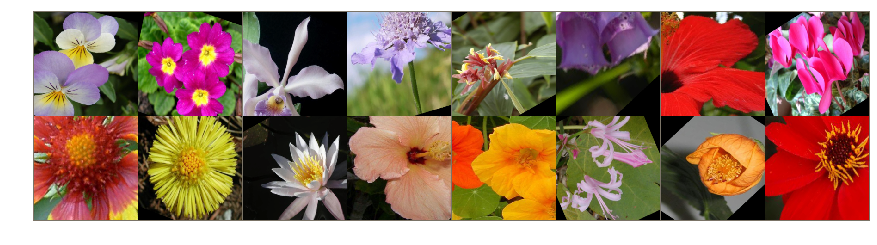

In [0]:
import torchvision
import matplotlib.pyplot as plt
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    plt.imshow(image)
    ax.axis('off') 
        
images, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images, nrow=8)
imshow(out)

In [0]:
# choose the model
model = models.resnet18(pretrained=True)

In [0]:
num_ftrs = model.fc.in_features
# change the outputs from 512 to 102
model.fc = nn.Linear(num_ftrs, 102)

In [0]:
#unfreezing your model (for better accuracy)
for param in model.parameters():
    param.requires_grad = True
    

In [0]:
#moveing to GPU
model.cuda()
#model.eval()

In [0]:
#training/validating function 
# this part of code is from https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad
#I changed minor things for my convinience
def train_model(model, criteria, optimizer, scheduler,    
                                      num_epochs=25, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs ))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
    
    # 
criteria = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Number of epochs
eps=5


In [0]:
#the actual training/validating 
model = train_model(model, criteria, optimizer, scheduler, eps, 'cuda')


In [0]:
#Saving the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({
            'state_dict': model.state_dict(),
             
            'class_to_idx': model.class_to_idx}, 
            "classifier.pth")
#torch.save(model.sate_dict, "classifier.pt")
